In [12]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np


from torchviz import make_dot, make_dot_from_trace

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

### Select Device ( GPU or CPU)
we will select device. there are two options: GPU or CPU. GPU technology is so faster than CPU technology. We will select GPU device. If your System is not include GPU technology, our function select CPU device.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Hyper Parameters
Hyper Paramaeters change each network and there is no rule to select hyper parameters. so we select most uses variable.

In [3]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.003

### Define Dataset


In [4]:
train_dataset = torchvision.datasets.MNIST(root='../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

###  Data Loader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### Visualization Dataset

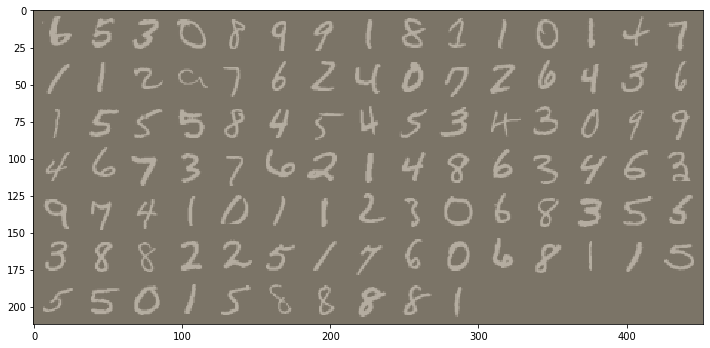

In [13]:
for images, labels in train_loader:
    break
im = make_grid(images,nrow=15)
inv_normalize = transforms.Normalize(
        mean= [-0.485/0.225,
              -0.456/0.224,
              -0.406/0.225],
        std= [1/0.225, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,24))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

### Build Network

In [14]:
class BRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True, bidirectional = True)
        self.fc = nn.Linear( hidden_size*2, num_classes)
        
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = BRNN( input_size, hidden_size, num_layers, num_classes).to(device)

###  Visualization Network

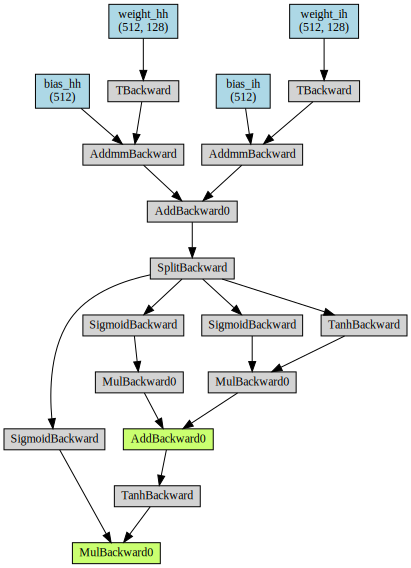

In [16]:
lstm_cell = nn.LSTMCell(128, 128)
x = torch.randn(1, 128)
make_dot(lstm_cell(x), params=dict(list(lstm_cell.named_parameters())))

### Loss and Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam( model.parameters(), lr= learning_rate )

###  Training

In [37]:
total_step = 0
train_loss = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        train_loss.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
           print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/2], Step [100/0], Loss: 0.0089
Epoch [1/2], Step [200/0], Loss: 0.0770
Epoch [1/2], Step [300/0], Loss: 0.0369
Epoch [1/2], Step [400/0], Loss: 0.0335
Epoch [1/2], Step [500/0], Loss: 0.0277
Epoch [1/2], Step [600/0], Loss: 0.0269
Epoch [2/2], Step [100/0], Loss: 0.0668
Epoch [2/2], Step [200/0], Loss: 0.0277
Epoch [2/2], Step [300/0], Loss: 0.1486
Epoch [2/2], Step [400/0], Loss: 0.0258
Epoch [2/2], Step [500/0], Loss: 0.0414
Epoch [2/2], Step [600/0], Loss: 0.0420


In [21]:
with torch.no_grad():
    
    correct = 0
    total = 0 
    
    for images, labels in test_loader:
        
        images = images.reshape( -1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))
    

Test Accuracy of the model on the 10000 test images: 97.36 %


### Save Model

In [22]:
torch.save(model.state_dict(), 'model.ckpt')


### Visualization Results

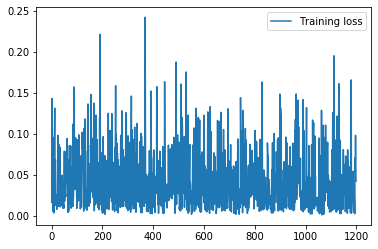

In [39]:
plt.plot(train_loss, label='Training loss')
plt.legend()
plt.show()